# ZVAR Tools

### Data Sources

In this notebook, we give a few basic example of what you can do with zvartools, especially how to access data sources. At the moment, we support 3 distinct data sources:
- Local: data stored locally on your machine
- Remote: data stored on a remote server, fetched via SCP (ssh credentials required)
- API: data also stored on a remote server, fetched via an API (API user and password required)

Since ZVAR does not come with a public-facing database, any query you run will result in the relevant data being copied over to your local machine. So, until a queryable database is available, we suggest:
- Using the pre-made datasets of variability candidates, found in the `data/demo_data` folder
- Simply being cautious when running conesearches or other queries that might return data from a large area of the sky, as these would result in a large amount of data being copied over to your local machine.

---

To begin with, we need to import the necessary modules.

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from zvartools.data import LocalDataSource, APIDataSource
from zvartools.plot import plot_folded_lightcurve, plot_periodicity, plot_gaia_cmd

Now, we'll define a data source. Let's start with the simplest one: local data. We'll also restrict the accessible data to primary fields only, to avoid copying over large amounts of data. 

In [2]:
local_lightcurve_path = "data/test/lightcurves"
local_period_path = "data/test/periods"

local_data_source = LocalDataSource(
    local_lightcurve_path, local_period_path, verbose=True, secondary=False
)

Maybe you do not have data locally yet, in which case you can:
- use the demo data provided in the `data/demo_data` folder.
- define an instance of the Remote or API data sources, here's how you'd do it for the latter:

In [3]:
api_url = "http://localhost:4000"
api_username = "admin"
api_password = "admin"

api_data_source = APIDataSource(
    local_lightcurve_path,
    local_period_path,
    api_url,
    api_username,
    api_password,
    verbose=True,
    secondary=False,
)

Before we proceed, we can call the `test_api_connection` method to check if the API connection is working.

In [4]:
api_data_source.test_api_connection()

True

*If you received False and an error, either the API is down or your credentials and/or the API URL are incorrect.*

Before we move on to the next section, let's pick with data source we want to use. This is done so that we can use the same data source throughout the notebook, and you can easily switch between data sources by changing the `data_source` variable.

In [5]:
data_source = local_data_source

---

### Querying the Data Source

Let's take a look at a few examples of what you can do with the data sources, to retrieve ZVAR objects. Essentially, you can:
- Query the data source for ZVAR objects, using a variety of methods (e.g. conesearch, by ID, etc.)
- Load pre-compiled datasets of ZVAR objects, stored in the `data/demo_data` folder
- Load their lightcurves
- Filter on the candidate's properties

Let's start by looking at how to run a conesearch query. First we defined the ra/dec of an object of interest:

In [6]:
ra, dec = 359.41839599609375, 35.18156051635742

When running conesearches, you can use list of RA/Dec tuples, astropy SkyCoord objects, or any dictionnary/class with 'ra' and 'dec' attributes. You'll also need to specify the search radius, in arcseconds. Here are some examples:

In [7]:
# with RA/Dec tuples as input
target = (ra, dec)
xmatches, lightcurves = data_source.cone_search([target], 2.0)
print(f"Found {len(xmatches[(ra, dec)])} cross-matches with tuple")

# with astropy SkyCoord as input
target = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame="icrs")
xmatches, lightcurves = data_source.cone_search([target], 2.0)
print(f"Found {len(xmatches[(ra, dec)])} cross-matches with SkyCoord")

# with a list of dictionaries with ra dec keys
target = {"ra": ra, "dec": dec}
xmatches, lightcurves = data_source.cone_search([target], 2.0)
print(f"Found {len(xmatches[(ra, dec)])} cross-matches with dictionary")

print(xmatches[(ra, dec)])

Found 4 cross-matches with tuple
Found 4 cross-matches with SkyCoord
Found 4 cross-matches with dictionary
[ID: 150213594184048466, RA: 359.41839599609375, Dec: 35.18156051635742, Valid: 0.0, Best M: 20, freq: -1.0, FAP: -1.0 (field: 648, ccd: 11, quad: 1), ID: 150213594184048466, RA: 359.41839599609375, Dec: 35.18156051635742, Valid: 0.0, Best M: 20, freq: -1.0, FAP: -1.0 (field: 648, ccd: 11, quad: 1), ID: 150213594184048466, RA: 359.41839599609375, Dec: 35.18156051635742, Valid: 0.0, Best M: 20, freq: -1.0, FAP: -1.0 (field: 648, ccd: 11, quad: 2), ID: 150213594184048466, RA: 359.41839599609375, Dec: 35.18156051635742, Valid: 0.0, Best M: 20, freq: -1.0, FAP: -1.0 (field: 648, ccd: 11, quad: 2)]


/Users/theodlz/projects/zvartools/src/zvartools/lightcurves.py:116: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(flux - np.nanmedian(flux)))


As you might have noticed, the conesearch returns:
- a dictionnary, where the keys are the (ra, dec) tuples from your input, and the values are the list of ZVAR objects found at that position
- another dicitonnary, where the keys are the IDs of the ZVAR objects found, and the values are the corresponding lightcurves (multi-band)

This way, if the same ZVAR objects matches with multiple of your input positions, we avoid duplicating the lightcurves. Also, it makes it easier if you want to first filter on the ZVAR objects' properties, before accessing their lightcurves.

You could also search by PanSTARRS ID, using the `psid_search` method. Here's an example:

In [8]:
psid = 150213594184048466

xmatches, lightcurves = data_source.psid_search([psid])
print(f"Found {len(xmatches[psid])} cross-matches with PSID")

Found 2 cross-matches with PSID


While you queried 1 PSID, you will likely get multiple ZVAR objects back. This is because the ZVAR data is partitioned and processed by ZTF field, ccd, quad, and filter. So, if the same object is observed in multiple fields and in multiple filters, we have periods for each. Instead of deciding with period is best for you, we decided to return all of them. You can then filter on the properties of the ZVAR objects to keep only the ones you're interested in. The lightcurves themselves are merged for a given PSID, so you don't have to worry about that.

As mentioned earlier, we also pre-compute some datasets of "high confidence" variability candidates. As of right now, these are selected by computing a CDF (Cumulative Distribution Function) of their significance, and keeping only the top 0.1% of candidates. Here's how you can load one of these datasets, found in the `data/demo_data` folder:

In [9]:
fields = [648]

candidates = data_source.load_variability_candidate_dataset(
    fields=fields, path="../data/demo_data/candidates"
)

print(f"Loaded {len(candidates)} candidates")

Loaded 2271 candidates


In [10]:
print(candidates[0])

ID: 143530039733689559, RA: 3.9733810424804688, Dec: 29.615808486938477, Valid: 0.9660633206367493, Best M: 5, freq: 9.189233779907227, FAP: 0.0001912411550957227 (field: 648, ccd: 1, quad: 4)
    PS1: G: 19.37±0.03, R: 18.12±0.00, I: 17.63±0.04, Z: 17.24±0.02, Y: 17.31±0.05
    Gaia: G: 18.23, BP: 19.05, RP: 17.24, Parallax: 0.21±0.18, PMRA: 9.76±0.22, PMDEC: 0.75±0.16
    2MASS: J: 16.39±nan, H: 15.87±nan, K: 15.38±nan
    AllWISE: W1: 15.21±0.04, W2: 15.33±0.09, W3: 12.60±nan, W4: 8.86±nan


As you can see, the results are similar. Since there might be a lot of objects in the dataset, this function only loads them but doesn't load the lightcurves. We suggest only accessing the lightcurves themselves once you've selected the objects you're interested in. Here is an example of how you could do that:

In [11]:
# let's select a subsetof "giants", based on their Gaia BP-RP color

giant_candidates = [
    candidate
    for candidate in candidates
    if (
        candidate.gaia.BP_RP is not None
        and candidate.gaia.BP_RP > 1.0
        and candidate.gaia.MG is not None
        and candidate.gaia.MG < 3.0
    )
]
print(f"Selected {len(giant_candidates)} giant candidates")

# let's also keep only the ones detected at least in r-band
giant_candidates = [
    candidate
    for candidate in giant_candidates
    if candidate.band is not None and candidate.band == "r"
]

print(f"Selected {len(giant_candidates)} giant candidates detected in r-band")

# let's also focus on those with a period around ~20 hours
giant_candidates = [
    candidate
    for candidate in giant_candidates
    if candidate.period is not None and 19.0 <= candidate.period <= 21.0
]

print(f"Selected {len(giant_candidates)} giant candidates with period around 20 hours")

print(giant_candidates[0])

Selected 72 giant candidates
Selected 27 giant candidates detected in r-band
Selected 1 giant candidates with period around 20 hours
ID: 151570049385578571, RA: 4.9385528564453125, Dec: 36.31493377685547, Valid: 1.0, Best M: 5, freq: 1.2246402502059937, FAP: 0.00027985486296344675 (field: 648, ccd: 13, quad: 1)
    PS1: G: 14.37±0.03, R: 13.79±0.00, I: 13.45±nan, Z: 13.34±0.03, Y: 13.38±0.02
    Gaia: G: 13.77, BP: 14.23, RP: 13.12, Parallax: 0.59±0.02, PMRA: -0.97±0.01, PMDEC: -6.43±0.01
    2MASS: J: 12.18±nan, H: 11.75±nan, K: 11.63±nan
    AllWISE: W1: 11.65±0.02, W2: 11.64±0.02, W3: 11.40±0.12, W4: 9.25±nan


In this case we are left with only one candidate, hurray! Let's see where it stands on the gaia color-magnitude diagram:

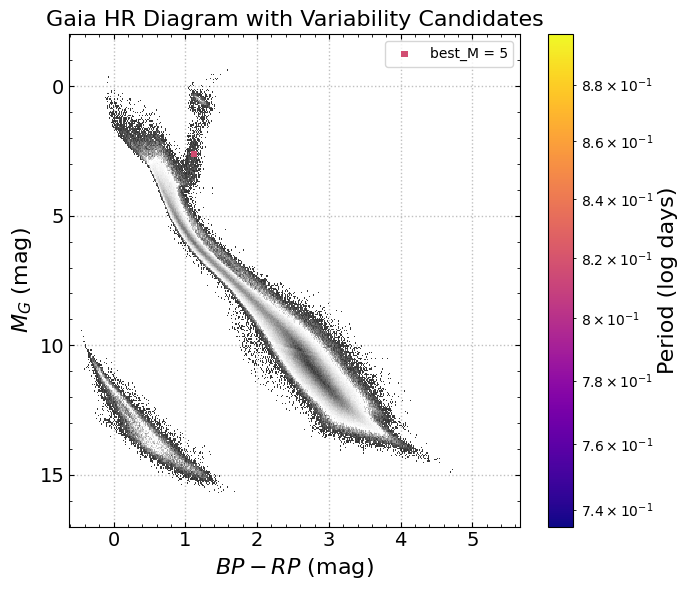

In [12]:
plot_gaia_cmd(giant_candidates, figsize=(7, 6))

Next, let's retrieve it's lightcurve and plot it folded on it's period:

In [13]:
lightcurves = data_source.get_candidates_lightcurves(giant_candidates)

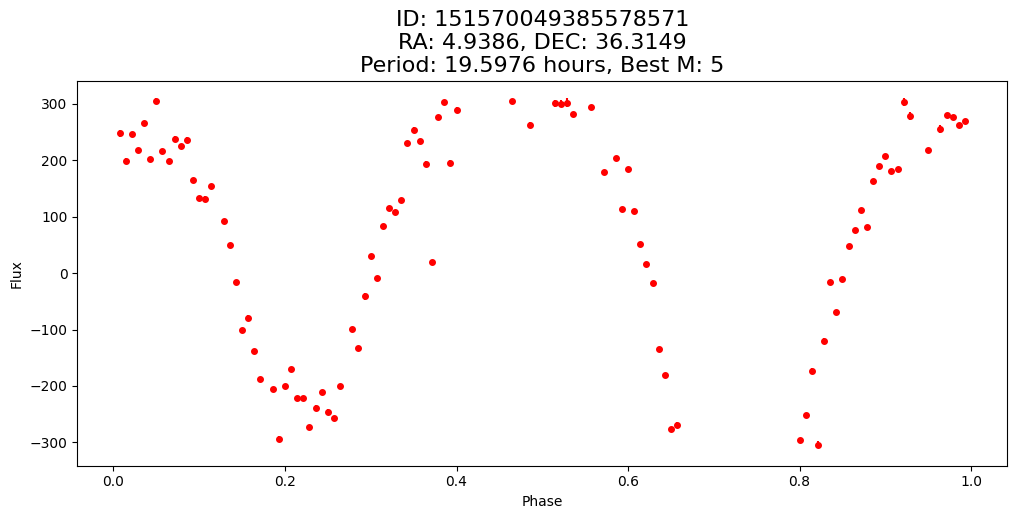

In [14]:
for cand in giant_candidates:
    lc = lightcurves[cand.psid]
    try:
        plot_folded_lightcurve(cand, lc, figsize=(12, 5), bins=140)
    except Exception as e:
        print(f"Error plotting candidate {cand.psid}: {e}")
        continue

Ok, this one definitely looks like a variable star. Next, let's see if we can re-compute it's period using the `fpw` package.

### Computing periods

`fpw` is the algorithm of choice for computing periods in ZVAR. While for the bulk processing of all ZTF lightcurves we use a GPU-powered and batched version of the algoritm in `C`, the python version can still be used to compute individual periods. The data source classes offer a wrapper around fpw, that can return the N best periods in any unit of your choice (+the full periodogram for plotting purposes), taking a lightcurve as input. Here's how you can use it:

In [15]:
candidate = giant_candidates[-1]
phot = lightcurves[candidate.psid].copy()

periods, significance, fpw_pgram = data_source.fpw_periodogram(
    phot, band="r", period_unit="hours"
)
print(f"Best period: {periods[0]:.4f} hours (power: {significance[0]:.4f})")

Best period: 19.5973 hours (power: 109680.9297)


We can see that it matches the period reported by ZVAR, great! Last but not least, let's take a quick look at the periodogram itself:

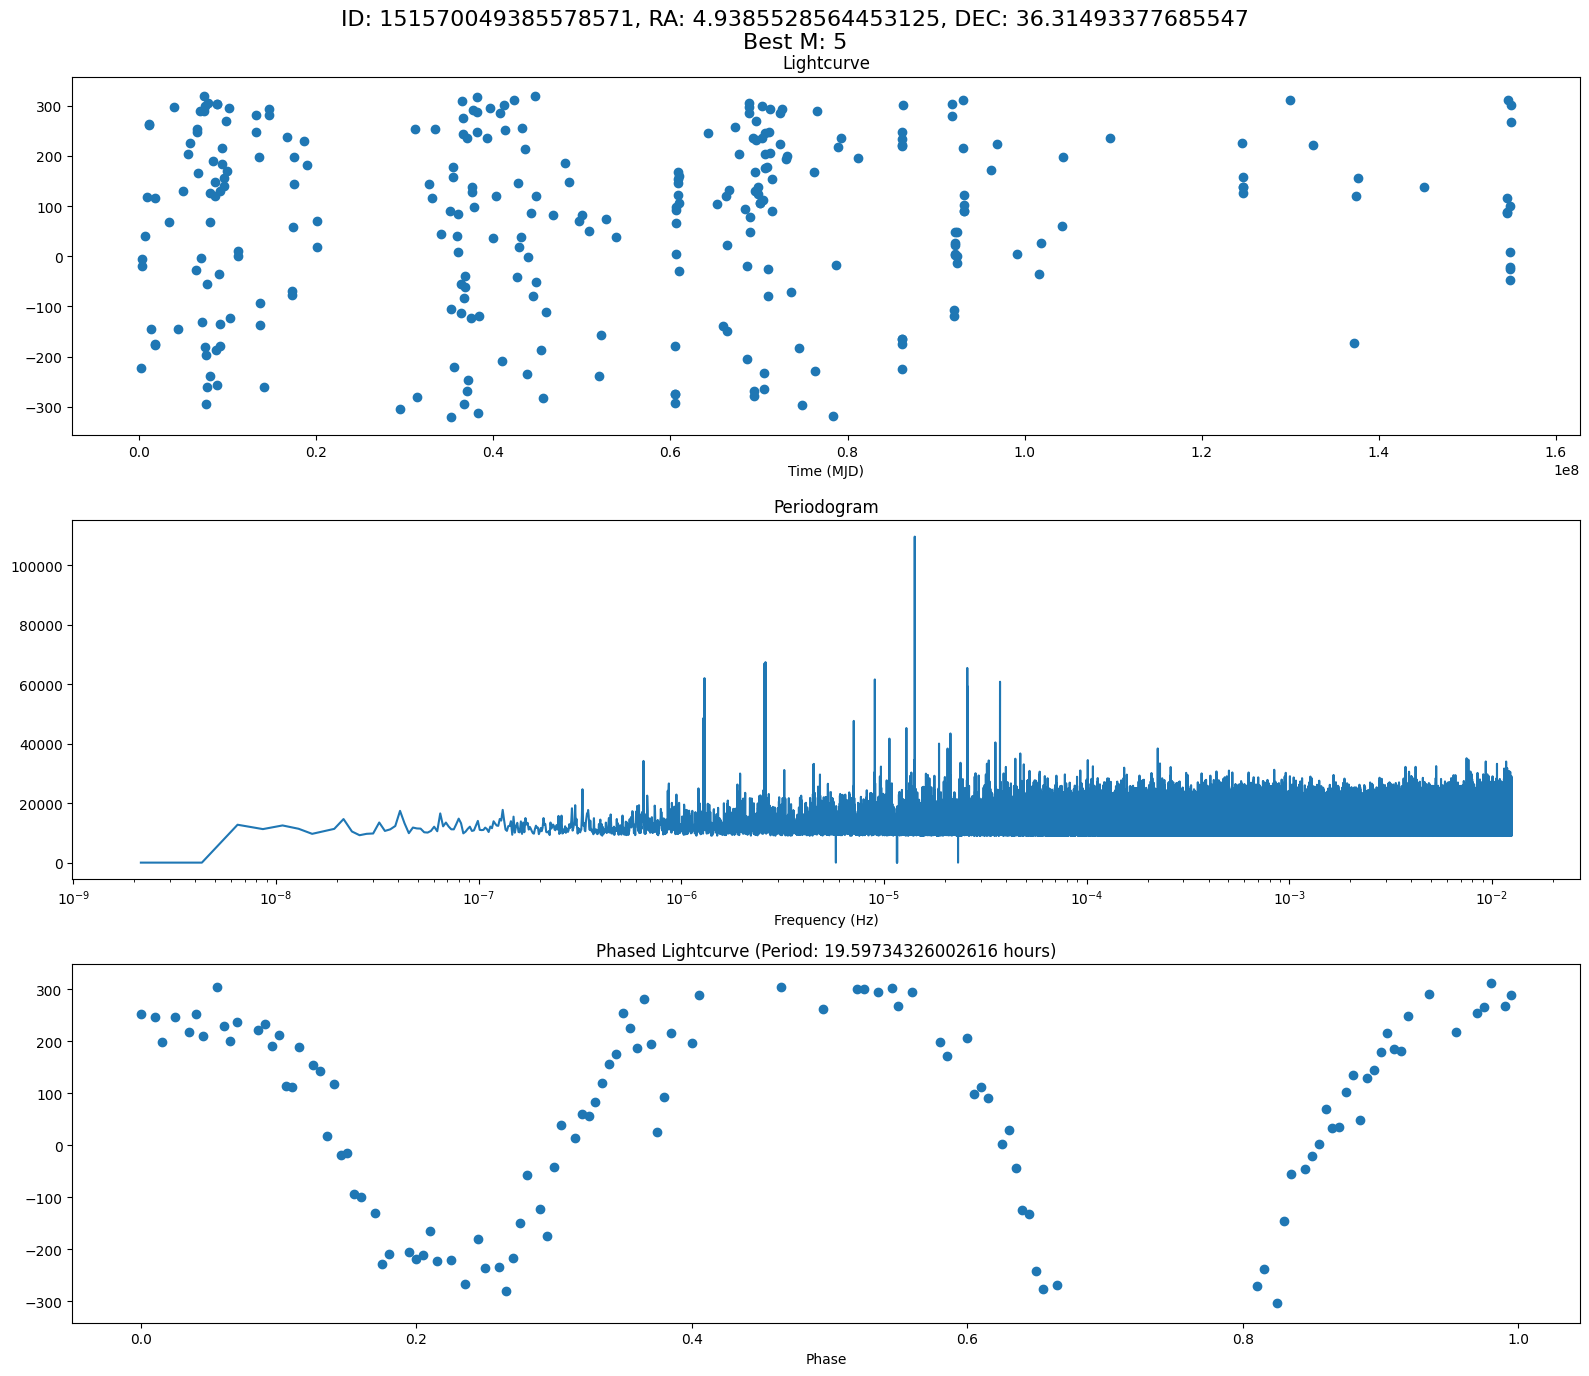

In [16]:
plot_periodicity(
    candidate,
    phot,
    fpw_pgram,
    periods[0],
    period_unit="hours",
    show_plot=True,
    figsize=(16, 14),
    bins=200,
)